In [2]:
import os
import numpy as np
import pandas as pd
import math
import matplotlib.pylab as plt
import seaborn as sns

%matplotlib inline
sns.set(style='ticks', palette='Set2')

In [141]:
# Load & preprocess data

df = pd.read_excel('Customer_Churn.xlsx').dropna()

# Transform non-target category variables into values:
    # COLLEGE = 0 if no, 1 if yes
df['COLLEGE'].replace(['zero','one'], 
                      [0,1], inplace=True)
    # REPORTED_SATISFACTION on a standard 1 = low, 5 = high scale
df['REPORTED_SATISFACTION'].replace(['very_unsat','unsat','avg','sat','very_sat'],                                [1,2,3,4,5], inplace=True)
    # REPORTED_USAGE_LEVEL on a standard 1 = low, 5 = high scale
df['REPORTED_USAGE_LEVEL'].replace(['very_little','little','avg','high','very_high'],
                                   [1,2,3,4,5], inplace=True)
    # CONSIDERING_CHANGE_OF_PLAN on a standard 1 = unlikely, 5 = likely scale
df['CONSIDERING_CHANGE_OF_PLAN'].replace(['never_thought','no','perhaps','considering','actively_looking_into_it'],
                                         [1,2,3,4,5], inplace=True)

# Rescale continuous variables to a value between 0 and 1 using min-max normalization
df['INCOME'] = (df['INCOME']-df['INCOME'].min())/(df['INCOME'].max()-df['INCOME'].min())
df['HOUSE'] = (df['HOUSE']-df['HOUSE'].min())/(df['HOUSE'].max()-df['HOUSE'].min())
df['OVERAGE'] = (df['OVERAGE']-df['OVERAGE'].min())/(df['OVERAGE'].max()-df['OVERAGE'].min())
df['HANDSET_PRICE'] = (df['HANDSET_PRICE']-df['HANDSET_PRICE'].min())/(df['HANDSET_PRICE'].max()-df['HANDSET_PRICE'].min())
df['AVERAGE_CALL_DURATION'] = (df['AVERAGE_CALL_DURATION']-df['AVERAGE_CALL_DURATION'].min()
                              )/(df['AVERAGE_CALL_DURATION'].max()-df['AVERAGE_CALL_DURATION'].min())
df['OVER_15MINS_CALLS_PER_MONTH'] = (df['OVER_15MINS_CALLS_PER_MONTH']-df['OVER_15MINS_CALLS_PER_MONTH'].min()
                                    )/(df['OVER_15MINS_CALLS_PER_MONTH'].max()-df['OVER_15MINS_CALLS_PER_MONTH'].min())

df.head()

# My hope is that by leaving the categories with wider distributions, the model will pick up more on any differences in them that might predict.

,COLLEGE,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,AVERAGE_CALL_DURATION,REPORTED_SATISFACTION,REPORTED_USAGE_LEVEL,CONSIDERING_CHANGE_OF_PLAN,LEAVE
0,0,0.085343,0.005935,6,0.192208,0.040312,0.000000,0.214286,2,2,2,STAY
1,1,0.115305,0.005935,13,0.765398,0.148244,0.000000,0.357143,2,2,4,STAY
2,1,0.051909,0.688427,0,0.182410,0.092328,0.551724,1.000000,2,1,3,STAY
3,0,0.714858,0.118694,33,0.750868,0.845254,0.103448,0.071429,2,5,4,LEAVE
4,1,0.065783,0.623145,85,0.087979,0.144343,0.724138,0.000000,1,2,1,STAY


In [187]:
df.tail()

,COLLEGE,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,AVERAGE_CALL_DURATION,REPORTED_SATISFACTION,REPORTED_USAGE_LEVEL,CONSIDERING_CHANGE_OF_PLAN,LEAVE
19995,0,0.951913,0.005935,23,0.256944,0.607282,0.034483,0.357143,5,2,5,STAY
19996,1,0.622385,0.216617,82,0.102818,0.622887,0.172414,0.071429,5,1,2,STAY
19997,0,0.418086,0.005935,66,0.026573,0.188557,0.000000,0.071429,2,5,4,LEAVE
19998,0,0.419122,0.145401,41,0.496949,0.205462,0.137931,0.071429,1,2,4,LEAVE
19999,0,0.747914,0.005935,0,0.818327,0.881664,0.827586,0.928571,2,4,5,LEAVE


In [142]:
df.describe().round(3)

,COLLEGE,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,AVERAGE_CALL_DURATION,REPORTED_SATISFACTION,REPORTED_USAGE_LEVEL,CONSIDERING_CHANGE_OF_PLAN
count,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000
mean,0.502,0.431,0.261,23.899,0.404,0.338,0.276,0.357,2.566,2.815,3.494
std,0.500,0.298,0.255,26.817,0.297,0.278,0.308,0.314,1.629,1.512,1.324
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,1.000
25%,0.000,0.159,0.006,0.000,0.134,0.116,0.034,0.071,1.000,2.000,2.000
50%,1.000,0.395,0.181,14.000,0.356,0.255,0.138,0.286,2.000,2.000,4.000
75%,1.000,0.685,0.537,41.000,0.650,0.524,0.517,0.643,5.000,5.000,4.000
max,1.000,1.000,1.000,89.000,1.000,1.000,1.000,1.000,5.000,5.000,5.000


LEAVE
LEAVE     9852
STAY     10148
dtype: int64
%LEAVE = 49.26


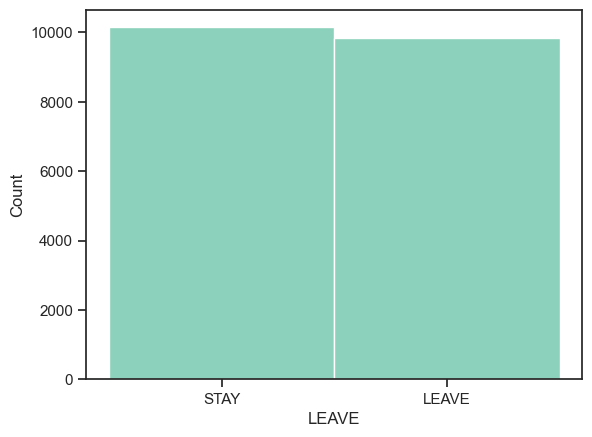

In [79]:
# View the target class distribution

print(df.groupby('LEAVE').size())
print('%LEAVE =', 100*(9852/20000))
sns.histplot(data=df, x=df['LEAVE'])
plt.show()

# The dataset is fairly balanced, with slightly more leave than stay.

In [ ]:
# Visualize difference between distribution for income

for r in range(2):
    hist = df[df.LEAVE == r].hist('INCOME')
    plt.title('Income where LEAVE =' + str(r))
    plt.show()

In [ ]:
# Visualize difference between distribution for overages

for r in range(2):
    hist = df[df.LEAVE == r].hist('OVERAGE')
    plt.title('Overages where LEAVE =' + str(r))
    plt.show()

In [ ]:
#Create a plot to see data alongside each other. This has an error I haven't resolved because I don't fully understand what it's doing.

# Column names
categorical_cols = ['COLLEGE','REPORTED_SATISFACTION','REPORTED_USAGE_LEVEL','CONSIDERING_CHANGE_OF_PLAN']
continuous_cols = ['INCOME','OVERAGE','LEFTOVER','HOUSE','HANDSET_PRICE','OVER_15MINS_CALLS_PER_MONTH','AVERAGE_CALL_DURATION']
target_col = 'LEAVE'
predictor_cols = categorical_cols + continuous_cols

rows = 2
fig, axs = plt.subplots(ncols=cols, nrows=rows, figsize=(7*cols, 7*rows))
axs = axs.flatten()
posn = 0

# Plot continuous features
for col in continuous_cols:
    sns.boxplot(data=df, x=target_col, y=col, ax=axs[posn])
    axs[posn].set_ylabel(col)
    axs[posn].set_title('')
    posn+=1

In [156]:
# Separate out training and test sets

from sklearn.model_selection import train_test_split

y = df['LEAVE']
features = df.drop('LEAVE',axis=1)
X = features

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=41, shuffle=True)

In [197]:
from sklearn.tree import DecisionTreeClassifier

decision_tree = DecisionTreeClassifier(criterion='entropy', max_depth=3)
decision_tree.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3)

In [198]:
from sklearn import metrics
print('Accuracy = %.3f' % (metrics.accuracy_score(decision_tree.predict(X_test),y_test)))

Accuracy = 0.681


In [ ]:
# Get a sense for the decision tree with a text representation

text_representation = tree.export_text(decision_tree)
print(text_representation)

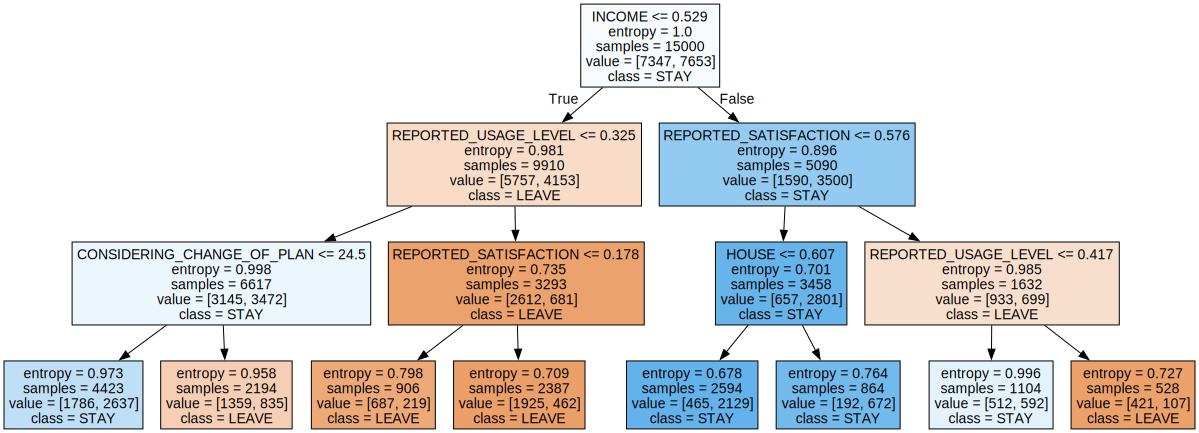

In [199]:
# Display a graph of the tree

from sklearn.tree import export_graphviz
import graphviz

dot_data = tree.export_graphviz(decision_tree, out_file=None, feature_names=predictor_cols, class_names=np.array(sorted(df['LEAVE'].unique())).astype('str').tolist(), filled=True)
graph = graphviz.Source(dot_data, format='png')
graph

In [184]:
# Perform K Nearest Neighbor calculation
from sklearn.neighbors import KNeighborsClassifier as knc
knn = knc(n_neighbors=10)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=10)

In [185]:
print('Accuracy = %.3f' % (metrics.accuracy_score(knn.predict(X_test),y_test)))

Accuracy = 0.574
